In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

drive.mount('/content/drive')

# ✅ Load datasets
datasets = {
    "Ampara": "/content/drive/My Drive/Cluster_2/Ampara_hourly.csv",
    "Batticaloa": "/content/drive/My Drive/Cluster_2/Batticaloa_hourly.csv",
    "Monaragala": "/content/drive/My Drive/Cluster_2/Monaragala_hourly.csv"
}

def preprocess_dataframe(df):
    df["timestamp_index"] = pd.to_datetime(df["timestamp_index"])
    df.set_index("timestamp_index", inplace=True)
    return df

dfs = {name: preprocess_dataframe(pd.read_csv(path)) for name, path in datasets.items()}

# ✅ Select Features
features = ["PM2.5 (ug/m3)", "hour", "day", "dayofweek", "month"]

# ✅ Normalization
pm25_scaler = MinMaxScaler()
feature_scaler = MinMaxScaler()

for name in dfs:
    dfs[name]["PM2.5 (ug/m3)"] = pm25_scaler.fit_transform(dfs[name][["PM2.5 (ug/m3)"]])
    dfs[name] = pd.DataFrame(feature_scaler.fit_transform(dfs[name][features]), columns=features, index=dfs[name].index)

# ✅ Function to create sequences (past 7 days → next 24 hours)
def create_sequences(data, past_hours=24, future_hours=1):
    X, y = [], []
    for i in range(len(data) - past_hours - future_hours):
        X.append(data[i:i+past_hours])
        y.append(data[i+past_hours:i+past_hours+future_hours, 0])
    return np.array(X), np.array(y)

# ✅ Prepare sequences for LSTM
seq_length = 24
target_hours = 1
X_data, y_data = [], []

for name in dfs:
    X, y = create_sequences(dfs[name].values, seq_length, target_hours)
    X_data.append(X)
    y_data.append(y)

# ✅ Combine datasets
X_combined = np.concatenate(X_data, axis=0)
y_combined = np.concatenate(y_data, axis=0)



Mounted at /content/drive


In [ ]:
# ✅ Split data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42, shuffle=True)

# ✅ Define the LSTM Model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(100, activation="relu"),
    Dense(target_hours)
])

# ✅ Compile & Train Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))




/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - loss: 0.0101 - mae: 0.0688 - val_loss: 0.0070 - val_mae: 0.0513
Epoch 2/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 0.0067 - mae: 0.0530 - val_loss: 0.0074 - val_mae: 0.0516
Epoch 3/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - loss: 0.0065 - mae: 0.0504 - val_loss: 0.0059 - val_mae: 0.0440
Epoch 4/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - loss: 0.0059 - mae: 0.0455 - val_loss: 0.0053 - val_mae: 0.0445
Epoch 5/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - loss: 0.0055 - mae: 0.0456 - val_loss: 0.0049 - val_mae: 0.0403
Epoch 6/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - loss: 0.0049 - mae: 0.0420 - val_loss: 0.0050 - val_mae: 0.0412
Epoch 7/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - loss: 0.0054 - mae: 0.0432 - val_loss: 0.0051 - val_mae: 0.0406
Epoch 8/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - loss: 0.0050 - mae: 0.0415 - val_loss: 0.0050 - val_mae: 0.0380
Epoch 9/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# ✅ Predict
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [ ]:
# ✅ Inverse Transform
y_train_pred = pm25_scaler.inverse_transform(y_train_pred)
y_test_pred = pm25_scaler.inverse_transform(y_test_pred)
y_train = pm25_scaler.inverse_transform(y_train)
y_test = pm25_scaler.inverse_transform(y_test)

# ✅ Compute Error Metrics
mse_train = mean_squared_error(y_train, y_train_pred, multioutput='raw_values').mean()
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred, multioutput='raw_values').mean()
r2_train = r2_score(y_train, y_train_pred, multioutput='uniform_average')

mse_test = mean_squared_error(y_test, y_test_pred, multioutput='raw_values').mean()
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred, multioutput='raw_values').mean()
r2_test = r2_score(y_test, y_test_pred, multioutput='uniform_average')

# ✅ Print Metrics
print("\n📌 Error Metrics for Training Data:")
print(f"  - MSE:  {mse_train:.4f}")
print(f"  - RMSE: {rmse_train:.4f}")
print(f"  - MAE:  {mae_train:.4f}")
print(f"  - R²:   {r2_train:.4f}")

print("\n📌 Error Metrics for Testing Data:")
print(f"  - MSE:  {mse_test:.4f}")
print(f"  - RMSE: {rmse_test:.4f}")
print(f"  - MAE:  {mae_test:.4f}")
print(f"  - R²:   {r2_test:.4f}")


📌 Error Metrics for Training Data:
  - MSE:  7.2938
  - RMSE: 2.7007
  - MAE:  1.6734
  - R²:   0.6523

📌 Error Metrics for Testing Data:
  - MSE:  7.9614
  - RMSE: 2.8216
  - MAE:  1.6848
  - R²:   0.6372


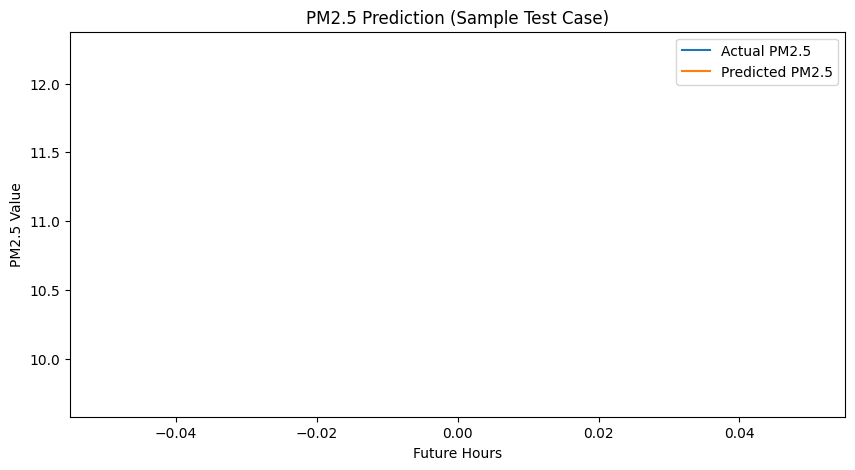

In [ ]:
# ✅ Plot Sample Test Predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test[0], label="Actual PM2.5")
plt.plot(y_test_pred[0], label="Predicted PM2.5")
plt.legend()
plt.title("PM2.5 Prediction (Sample Test Case)")
plt.xlabel("Future Hours")
plt.ylabel("PM2.5 Value")
plt.show()

In [ ]:
# === Function to add predictions into original CSV ===
def add_predictions_to_original_csv(model, filepath, station_name, seq_length=24, output_size=1):
    # Load the original CSV
    df_orig = pd.read_csv(filepath)
    df_orig["timestamp_index"] = pd.to_datetime(df_orig["timestamp_index"])
    df_orig.set_index("timestamp_index", inplace=True)

    # --- Preprocess same as training ---
    df_proc = df_orig.copy()
    df_proc["PM2.5 (ug/m3)"] = pm25_scaler.transform(df_proc[["PM2.5 (ug/m3)"]])
    df_proc = pd.DataFrame(
        feature_scaler.transform(df_proc[features]),
        columns=features,
        index=df_proc.index
    )

    # --- Create sequences & predict ---
    X, y = create_sequences(df_proc.values, seq_length, output_size)
    y_pred = model.predict(X)

    # Inverse scaling
    y_pred = pm25_scaler.inverse_transform(y_pred).flatten()

    # Align with timestamps
    prediction_index = df_proc.index[seq_length: seq_length + len(y_pred)]

    # Add new column in original DataFrame
    df_orig.loc[prediction_index, "Predicted_PM2.5"] = y_pred

    # Save to new file
    save_path = f"/content/drive/My Drive/Cluster_2/{station_name}_with_predictions.csv"
    df_orig.to_csv(save_path)
    print(f"✅ Saved predictions for {station_name} → {save_path}")

# === Run for all stations ===
for name, path in datasets.items():
    add_predictions_to_original_csv(model, path, name, seq_length=seq_length, output_size=target_hours)


167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
✅ Saved predictions for Ampara → /content/drive/My Drive/Cluster_2/Ampara_with_predictions.csv
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
✅ Saved predictions for Batticaloa → /content/drive/My Drive/Cluster_2/Batticaloa_with_predictions.csv
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
✅ Saved predictions for Monaragala → /content/drive/My Drive/Cluster_2/Monaragala_with_predictions.csv


In [ ]:
import pandas as pd

# === Columns to keep (everything else will be dropped) ===
columns_to_keep = ["timestamp_index", "PM2.5 (ug/m3)", "hour", "day", "dayofweek", "month", "Predicted_PM2.5"]

# === Process all new prediction files ===
for name in datasets.keys():
    pred_file = f"/content/drive/My Drive/Cluster_2/{name}_with_predictions.csv"

    # Load the prediction-added file
    df = pd.read_csv(pred_file)

    # Keep only the required columns
    df = df[columns_to_keep]

    # Save as new clean file
    save_path = f"/content/drive/My Drive/Cluster_2/{name}_predictions_clean.csv"
    df.to_csv(save_path, index=False)

    print(f"✅ Cleaned prediction CSV saved for {name} → {save_path}")


✅ Cleaned prediction CSV saved for Ampara → /content/drive/My Drive/Cluster_2/Ampara_predictions_clean.csv
✅ Cleaned prediction CSV saved for Batticaloa → /content/drive/My Drive/Cluster_2/Batticaloa_predictions_clean.csv
✅ Cleaned prediction CSV saved for Monaragala → /content/drive/My Drive/Cluster_2/Monaragala_predictions_clean.csv
